# Ellipse fitting with gaussian, deprojection and profiles
**same for ZIMPOL and  IRDIS**

uses deconvolved data without coprrection for the PSF (to not disturb the morphology)



## Functions

In [1]:
#fitting ellipse to rings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
from astropy.io import fits
import os, fnmatch
import matplotlib.gridspec as gridspec
from scipy import optimize
from skimage.measure import EllipseModel
from scipy import interpolate
from textwrap import wrap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from skimage.measure import profile_line
import matplotlib.patches as patches
from scipy.optimize import curve_fit

import functions as f



#comments
#central ellipse is fitted using gaussian. 
#Gaussian is fitted in coordinates (-n/2, n/2) thats why at some point I add n/2 to correct for it and move ellipse points coordinates 
#back to array coordinates. For iras15 second ring is also fitted with gaussian. 
#Other arcs are fitted with an usual ellipse fitting routine (just to coordinates of pixels)


def LoadImage (dir,annulus):

    files = os.listdir(dir)
    for fil in files:
        if fnmatch.fnmatch(fil, '*'+annulus+'_decon.fits'):
            print(fil)
            hdu = fits.open(dir+fil)
            image = hdu[0].data
            ps =3.6
            n=image.shape[0]
            print(n)
            d=(n-1)/2
            x = np.linspace(-d, d, n)
            y = np.linspace(-d, d, n)
            x2, y2 = np.meshgrid(x, y)
            R = np.sqrt(x2**2+y2**2)
    return image, R, x, y, d,x2,y2

def LoadImage_noise (dir):

    files = os.listdir(dir)
    for fil in files:
        if fnmatch.fnmatch(fil, '*_decon.fits'):
            
            hdu = fits.open(dir+fil)
            img = hdu[0].data
            ps =3.6
            n_in = img.shape[0]
            image= img
            n=image.shape[0]
            
            d=(n-1)/2
            x = np.linspace(-d, d, n)
            y = np.linspace(-d, d, n)
            x2, y2 = np.meshgrid(x, y)
            R = np.sqrt(x2**2+y2**2)
    return image, R, x, y, d,x2,y2


def giveR(min=1e-5, max=12, n=300):
    return np.linspace(1e-5, 12, n)

def sampledir(angle, n):
    xd, yd = [], []
    R = giveR()
    for r in R:
        xd.append( r*np.cos(angle*np.pi/180.) )
        yd.append( r*np.sin(angle*np.pi/180.) )
    return np.array(xd), np.array(yd)

def giveProfile(img, x, y, angle):

    fimg = interpolate.RectBivariateSpline(x, y, img)
    xd, yd = sampledir(angle, 100)
    profile = []
    for xx, yy in zip(xd, yd):
        profile.append(fimg(xx, yy)[0][0])
    #fig, ax = plt.subplots(1, 1,figsize=(8,6))
    #plt.plot(giveR(), profile, '.')
    return np.array(profile)
    
def Gauss1D(R, amp, r0, size):
    model = amp * np.exp( -(R-r0)**2 / size )
    return model

def fitProfile(profile, r):
    amp = amp_dict[star]
    r0 = r0_dict[star]
    size = size_dict[star]
    if second_ring:  #for second ring of iras15
        amp = 20
        r0 = 10
        size =0.7
    a = [amp, r0, size]
    sigma = 1 / (profile**2 +1e-10)
    try: 
        popt, pcov = optimize.curve_fit( Gauss1D, giveR(), profile, p0=a, sigma=sigma, maxfev=10000)
    except:
        popt=a
        popt[0]=2.5e-4

    #plt.plot(giveR(), Gauss1D(giveR(), *popt))
    #plt.show()
    #plt.close()

    return popt[1], popt[0]

def GetRingCoord(img, x, y, nangles = 360):
    ## Gives the radius, PA, amplitude of the fitte gaussian to nangles angles with a center chose to be (x,y)
    angles = np.linspace(0, 360, nangles)
    radii, amps = [], []
    for ang in angles:
        profile = giveProfile(img, x, y, ang)
        rad, amp = fitProfile(profile, giveR())
        radii.append(rad)
        amps.append(amp)
    #print(profile)
    return np.array(radii), 90-np.array(angles), np.array(amps)

def gauss_ell_fit(img,x,y,ps,savefig,savefig1, star,annulus,Rlimit, imgru_cen):
    n=img.shape[0]
    shift=n/2-0.5

    rad, theta, amps = GetRingCoord(img, x, y, nangles = 360)

    d=n*ps/2
    fig, ax = plt.subplots(1, 1,figsize=(8,6))
    if star=='ru_cen_no_calib':
        plt.imshow(np.arcsinh(imgru_cen), extent=[-d, d, d, -d])    
    else:
        plt.imshow(np.arcsinh(img), extent=[-d, d, d, -d])
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    xring = rad*np.cos(theta*np.pi/180.)
    yring = rad*np.sin(theta*np.pi/180.)

    #print(amps)

    xrok, yrok = [], []

    for xr, yr, amp in zip(xring, yring, amps):
        Rr = np.sqrt(xr**2+yr**2)
        if Rr<Rlimit and second_ring==False:
            if amp > 2.5e-4:
                plt.plot( xr*ps, yr*ps, 's', color='green' )
                xrok.append(xr)
                yrok.append(yr)
            else:
                plt.plot( xr*ps, yr*ps, 'x', color='red' )
        if second_ring==True and Rr<Rlimit and Rr>6:
            if amp > 2.5e-4:
                plt.plot( xr*ps, yr*ps, 's', color='green' )
                xrok.append(xr)
                yrok.append(yr)
            else:
                plt.plot( xr, yr, 'x', color='red' )

    ring = np.vstack((xrok, yrok)).transpose()

    ell = EllipseModel()
    ell.estimate(ring)
    xc, yc, a, b, theta = ell.params
    
    points=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta))
    sigma_2=np.sum(ell.residuals(ring)**2)
    ac,bc=a,b
    reverse=False
    if a<b: 
        ac,bc=b,a
        print('reverse')
        reverse=True
    cosi=bc/ac
    ecc=np.sqrt(1-bc*bc/ac/ac)
    print('theta %.2f' % np.rad2deg(theta))
    angle=np.rad2deg(theta)
    #if angle<0: angle=angle+360
    if (a<b):
        if np.rad2deg(theta)<90:
            angle=angle+90
        else:
            angle=angle-90
            
  
    print('angle %.2f' % angle)
    plt.plot(points[:,0]*ps,points[:,1]*ps, color='cyan')
    plt.plot(xc*ps, yc*ps, '+', color='cyan')
    plt.title("\n".join(wrap(star+' ellipse gaussian fit for original values. a=%.2f, b=%.2f, i=%.2f' % (a, b,np.rad2deg(np.arccos(cosi))), 60)))
    northeast2(lim,ps,coef=3)
    if second_ring:
        plt.savefig(savefig1+ star+'_'+annulus+ "_ellipse_gauss_fit_2.jpeg",bbox_inches='tight', pad_inches=0.1)
    else:
        plt.savefig(savefig1+ star+'_'+annulus+ "_ellipse_gauss_fit.jpeg",bbox_inches='tight', pad_inches=0.1)
        
    plt.close()  


    return  points, xc, yc, a, b, theta, cosi, ecc, sigma_2, reverse, angle



def northeast2(lim,ps,coef=1):
    x_ar=(lim-3) * ps
    y_ar=(-lim+3) * ps
    plt.arrow(x_ar, y_ar, 0, 3*coef*ps, color='white',width=1,head_width=10, length_includes_head=True,head_length=15)
    plt.text(x_ar-0.2*coef * ps,y_ar+3.2*coef * ps,'N',fontsize=14,color="white")        
    plt.arrow(x_ar, y_ar, -3*coef*ps, 0, color='white',width=1,head_width=10, length_includes_head=True,head_length=15)
    plt.text(x_ar-3.8 *coef* ps,y_ar-0.2 *coef* ps,'E',fontsize=14,color="white") 


def northeast(lim,ps,ax,coef=1):
    x_ar=(lim-3) * ps
    y_ar=(-lim+3) * ps
    ax.arrow(x_ar, y_ar, 0, 3*coef*ps, color='white',width=1,head_width=10, length_includes_head=True,head_length=15)
    ax.text(x_ar-0.2*coef * ps,y_ar+3.2*coef * ps,'N',fontsize=14,color="white")        
    ax.arrow(x_ar, y_ar, -3*coef*ps, 0, color='white',width=1,head_width=10, length_includes_head=True,head_length=15)
    ax.text(x_ar-3.8*coef * ps,y_ar-0.2*coef * ps,'E',fontsize=14,color="white") 
   

def northeast_rotated(angle1,xc,yc,lim,ps,coef=1): 
    angle=np.deg2rad(-angle1)              
    x_ar=(lim-5) * ps
    y_ar=(-lim+5) * ps
    
    x_len=-(3*coef)*np.sin(angle)*ps
    y_len=(3*coef)*np.cos(angle)*ps
    x_len_t=-(3.5*coef)*np.sin(angle)*ps
    y_len_t=(3.5*coef)*np.cos(angle)*ps
    
    plt.arrow(x_ar, y_ar, x_len, y_len, color='white',width=1,head_width=10, length_includes_head=True,head_length=15)
    plt.text(x_ar+x_len_t,y_ar+y_len_t ,'N',fontsize=14,color="white") 
    x_len=(-3*coef)*np.cos(angle)*ps
    y_len=(-3*coef)*np.sin(angle)*ps
    x_len_t=(-3.8*coef)*np.cos(angle)*ps
    y_len_t=(-3.5*coef)*np.sin(angle)*ps   
    plt.arrow(x_ar, y_ar, x_len, y_len, color='white',width=1,head_width=10, length_includes_head=True,head_length=15)
    plt.text(x_ar+x_len_t,y_ar+y_len_t ,'E',fontsize=14,color="white")   

def northeast_rotated_depr(angle1,xc,yc,lim,cosi,ps,coef=1): 
    angle=np.deg2rad(-angle1)              
    x_ar=(lim-12) * ps
    y_ar=(-lim+5) * ps
    
    x_len=-(3*coef)*np.sin(angle)*ps
    y_len=(3*coef)*np.cos(angle)/cosi*ps
    x_len_t=-(3.8*coef)*np.sin(angle)*ps
    y_len_t=(3.5*coef)*np.cos(angle)/cosi*ps
    
    plt.arrow(x_ar, y_ar, x_len, y_len, color='white',width=1,head_width=10, length_includes_head=True,head_length=15)
    plt.text(x_ar+x_len_t,y_ar+y_len_t ,'N',fontsize=14,color="white") 
    x_len=(-3*coef)*np.cos(angle)*ps
    y_len=(-3*coef)*np.sin(angle)/cosi*ps
    x_len_t=(-3.8*coef)*np.cos(angle)*ps
    y_len_t=(-3.5*coef)*np.sin(angle)/cosi*ps      
    plt.arrow(x_ar, y_ar, x_len, y_len, color='white',width=1,head_width=10, length_includes_head=True,head_length=15)

    plt.text(x_ar+x_len_t,y_ar+y_len_t ,'E',fontsize=14,color="white")   

def northeast_rotated_depr_ax(angle1,xc,yc,lim,cosi,ps,ax,coef=1): 
    angle=np.deg2rad(-angle1)              
    x_ar=(lim-12) * ps
    y_ar=(-lim+5) * ps
    
    x_len=-(3*coef)*np.sin(angle)*ps
    y_len=(3*coef)*np.cos(angle)/cosi*ps
    x_len_t=-(3.8*coef)*np.sin(angle)*ps
    y_len_t=(3.5*coef)*np.cos(angle)/cosi*ps
    
    ax.arrow(x_ar, y_ar, x_len, y_len, color='white',width=1,head_width=10, length_includes_head=True,head_length=15)
    ax.text(x_ar+x_len_t,y_ar+y_len_t ,'N',fontsize=14,color="white") 
    x_len=(-3*coef)*np.cos(angle)*ps
    y_len=(-3*coef)*np.sin(angle)/cosi*ps
    x_len_t=(-3.8*coef)*np.cos(angle)*ps
    y_len_t=(-3.5*coef)*np.sin(angle)/cosi*ps      
    ax.arrow(x_ar, y_ar, x_len, y_len, color='white',width=1,head_width=10, length_includes_head=True,head_length=15)

    ax.text(x_ar+x_len_t,y_ar+y_len_t ,'E',fontsize=14,color="white")   


def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))

    
def find_FWHM (PSF,n):             #resolution
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))

    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2

    return fwhm


## Set up

In [44]:

stars=['HR4049_20190108',"HR4049_combined",'HR4226','UMon_Katya']

star=stars[1]

dirdat0 = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/'+star+'/' 
dirdat = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Deconvolution_corr_tel+unres/'+star+'/' 

fittype='Q_phi' #'PI' #here this variable correcpond to the type of image you want to analyse
annulus='V' #filter


amp_dict={'HR4049_20190108':120,'HR4049_20190107':120,'HR4049_combined':120,'V709_Car':100,'HR4226':100,'UMon_Katya':100}
r0_dict={'HR4049_20190108':10,'HR4049_20190107':10,'HR4049_combined':10,'V709_Car':10,'HR4226':5,'UMon_Katya':8}
size_dict={'HR4049_20190108':10,'HR4049_20190107':10,'HR4049_combined':10,'V709_Car':10,'HR4226':5,'UMon_Katya':5}
starnames = {'HD75885':'HD75885','AR_Pup_dc_notnorm':'AR Pup','HR4049_combined':'HR4049','HR4049_20190108':'HR4049/2019-01-08','HR4049_20190107':'HR4049/2019-01-07','IRAS08544-4431':'IRAS08544-4431','UMon':'U Mon','AR_Pup_flat4':'AR_Pup_flat4','V709_Car':'V709 Car','UMon_calibV390':'UMon_calibV390','HR4226':'HR4226','UMon_Katya':'U Mon'}

starsdict = {'HR4049_20190108':1449,'HR4049_20190107':1449,'HR4049_combined':3471,'UMon_Katya':800,'V709_Car':0,'HR4226':0}

# with this variable you can choose what analysis steps you want to perform and which not
deprojection=False
radialbrightness=False
linebrightness=False

azimuthalprofile=False


In [45]:


dir =dirdat +'deconvolved_'+fittype+'/'
print(star)



savefig1='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'ellipse_with_gaussian_'+fittype+'/'
try:
 # Create target Directory
   os.mkdir(savefig1)
except FileExistsError:
    print()
    
savefig1=savefig1+star+'/'
try:
 # Create target Directory
   os.mkdir(savefig1)
except FileExistsError:
    print()
    
savefig_prof=savefig1+'rad_profile/'
try:
 # Create target Directory
   os.mkdir(savefig_prof)
except FileExistsError:
    print()


savefig_azprof=savefig1+'azim_profile/'
try:
 # Create target Directory
   os.mkdir(savefig_azprof)
except FileExistsError:
    print()



second_ring=False #do not change it!
img_in, R, x, y, d_in,X,Y= LoadImage(dir,annulus)# loading deconvolved SPHERE image
Rlimit=100
print(R.shape)
img_in_0=img_in*1.0

lim=35
img = img_in * (R<Rlimit) * (R>1) ##mask in radius
image_plot=np.arcsinh(img)
n=img.shape[0]

I_decon, R, x, y, d_in,X,Y=  LoadImage(dirdat +'deconvolved_'+'I'+'/',annulus)
fwhm=find_FWHM (I_decon,n)    

fig, ax = plt.subplots(1, 1,figsize=(8,6))

ps=3.6
d=d_in*ps
plt.imshow(image_plot,vmax=np.max(image_plot),extent=(-d, d, d, -d))
plt.xlim(-lim * ps, lim * ps)
plt.ylim(-lim * ps, lim * ps)
x0=(511.5)*ps-d
y0=(511.5)*ps-d
plt.plot(x0,y0,'+',color='white')
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=20)

northeast2(lim,ps,coef=3)
circle1 =plt.Circle((-110,-110), (fwhm*ps/2), color='w')    
ax.add_patch(circle1)

plt.title("\n".join(wrap(annulus+'-band', 60)), fontsize=28)  #+' ellipse fit with gauss+arcs'
plt.xlabel('mas', fontsize=24)
plt.ylabel("mas", fontsize=24)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

plt.savefig(savefig1+ star+'_'+annulus+ "_data_for_fit.jpeg",bbox_inches='tight', pad_inches=0.1)    
plt.close()  

HR4049_combined




HR4049_combined_V_decon.fits
1024
(1024, 1024)
HR4049_combined_V_decon.fits
1024


## Ellipse fit

In [4]:
img2=img
Rlimit2=Rlimit

points, xc, yc, a, b, theta, cosi, ecc, sigma_2,reverse,angle=gauss_ell_fit(img2,x,y,ps,savefig1,savefig1,star,annulus,Rlimit2, img)


xc_in=xc*1.0
yc_in=yc*1.0
print(xc, yc, a, b, theta,str(np.rad2deg(np.arccos(cosi))),ecc)

logfile=open(savefig1+star+'_'+annulus+'_ellipse_gauss_fit.txt','w+')
logfile.writelines(star+'\n')
logfile.writelines('Annulus for stellar polarisation '+annulus+'\n')
logfile.writelines("center = (%f , %f) \n" % (xc*ps, yc*ps))
logfile.writelines("angle of rotation = %f \n" % theta)
logfile.writelines("half axes im mas= %f, %f \n" % (a*ps,b*ps))
logfile.writelines("sigma^2 = %f \n" % sigma_2)

logfile.writelines('Inclination for the deprojection '+str(np.rad2deg(np.arccos(cosi)))+'\n')
logfile.writelines('PA '+str(angle)+'\n')
logfile.writelines('Eccentricity '+str(ecc)+'\n')



 #height of arc
starposition=[(511.5-n/2),(511.5-n/2)] #center in python array index
ringshift=math.dist(starposition,[xc,yc])
sini=np.sqrt(1-cosi*cosi)

if ringshift>=1 or star=='iras15469-5311' or star=='iw_car_calib':
    print("center ring shift "+str(ringshift*ps)+' mas')

    height=ringshift*ps/sini

    heightau=height/3600000*np.pi/180*starsdict[star]*206264.806

    print('height '+str(height)+' mas; '+str(heightau)+' au')
    logfile.writelines('Ring shift'+'\n')
    logfile.writelines("Assumed distance "+str(starsdict[star])+' pc'+'\n')
    logfile.writelines("center ring shift "+str(ringshift*ps)+' mas'+'\n')
    logfile.writelines('height '+str(height)+' mas; '+str(heightau)+' au'+'\n')



logfile.writelines('\n')
logfile.close()



    



#if star=='iras08544-4431_calib' or star=='iras15469-5311' or star=='iw_car_calib' or star=='ac_her':




/tmp/ipykernel_3858/3062195345.py:91: RuntimeWarning: overflow encountered in exp
  model = amp * np.exp( -(R-r0)**2 / size )
/tmp/ipykernel_3858/3062195345.py:91: RuntimeWarning: overflow encountered in multiply
  model = amp * np.exp( -(R-r0)**2 / size )


theta 48.17
angle 48.17
0.5385814127210835 -0.3372027437594021 8.178493682648021 7.508892124892549 0.8407601105451479 23.346286119162475 0.3962873358928644
center ring shift 3.7845474888630855 mas
height 9.550008658076905 mas; 33.14808001247496 au


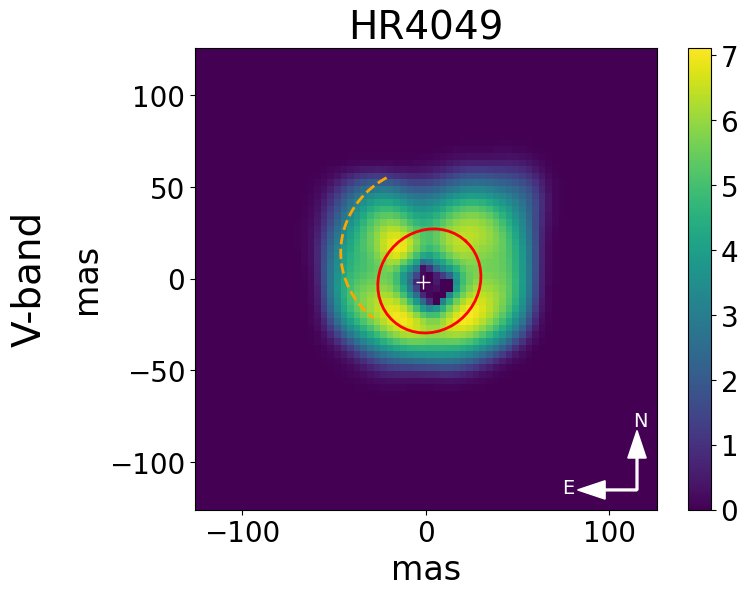

In [46]:
d=(n-1)*ps/2
fig, ax = plt.subplots(1, 1,figsize=(8,6))
plt.imshow(np.arcsinh(img_in), extent=[-d, d, d, -d])
northeast2(lim,ps,coef=3)
plt.xlim(-lim * ps, lim * ps)
plt.ylim(-lim * ps, lim * ps)

cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=20)    




if star==star:#'HR4049_combined':# and annulus=='I':
    ell = EllipseModel()
 
    #substructures
    xcs=1
    ycs=4
    a=50/ps
    b=a*np.cos(np.deg2rad(20))
    theta=np.deg2rad(0)

    points_substr1=ell.predict_xy(np.linspace(np.deg2rad(120), np.deg2rad(230), 50),params=(xcs,ycs,a,b,theta))
    points_substr2=ell.predict_xy(np.linspace(np.deg2rad(130), np.deg2rad(230), 50),params=(-xcs,-ycs,a,b,theta))

    plt.plot(points_substr1[:,0]*ps,points_substr1[:,1]*ps, lw=2,ls='--', color='orange')
    #plt.plot(points_substr2[:,0]*ps,points_substr2[:,1]*ps, lw=2,ls='--', color='orange')



plt.plot(points[:,0]*ps,points[:,1]*ps, lw=2, color='red')
plt.plot(xc*ps, yc*ps, '+',ms=10, color='red')

ax.plot((511.5-n/2)*ps,(511.5-n/2)*ps, "+",ms=10, color="white")
plt.xlabel('mas', fontsize=24)
plt.ylabel("mas", fontsize=24)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
if annulus=='V':
    plt.title("\n".join(wrap(starnames[star], 60)), fontsize=28)  #+' ellipse fit with gauss+arcs'


if star=='HR4049_combined':
    if annulus=='I':
        ax.text(-0.4, 0.5, annulus+"'-band", transform=ax.transAxes, fontsize=28, va='center', rotation=90)

    else:
        ax.text(-0.4, 0.5, annulus+'-band', transform=ax.transAxes, fontsize=28, va='center', rotation=90)

plt.savefig(savefig1+ star+'_'+annulus+ "_ellipse_gauss_fit_all.jpeg",bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()  

d=d_in
xc=xc+d
yc=yc+d

## Deprojection

In [6]:
if deprojection:
     #DEPROJECTION

    #img, R, x, y, d= LoadImage(dir)
    #img=np.arcsinh(img_in)

    img=img_in*1.0
    


    angle_rot=np.deg2rad(-angle) #because image is plotted upside down (result of pythons array numeration) and rotate_image looks like working in the opposite direction

    ell = EllipseModel()   
    image_rotated=f.rotate_image(img,angle,xc,yc)


    points_rotx,points_roty=f.rotate_points_el(points[:,0],points[:,1],angle_rot,xc-d,yc-d)
    points_rotx=points_rotx+d
    points_roty=points_roty+d
    


    d = (n-1)*ps/2
    lim=35
    fig, ax = plt.subplots(1, 1,figsize=(8,6))
    #image_rotated=np.sinh(image_rotated)*1.0*R*R
    plt.imshow(np.arcsinh(image_rotated),vmax=np.max(np.arcsinh(image_rotated)), extent=(-d, d, d,-d))
    plt.plot(points_rotx*ps-d,points_roty*ps-d, lw=2, color='red')
    if star=='iras15469-5311': 
         plt.plot(points_sec_rotx*ps-d,points_sec_roty*ps-d,'--', lw=2, color='orange')

    if star=='iras08544-4431_calib' or star=='ac_her':
        plt.plot(points_arc_rotx*ps-d,points_arc_roty*ps-d,'--', lw=2, color='orange')
        ax.plot(arcxrot*ps-d,arcyrot*ps-d, "+", ms=10 , color="orange")
    if star=='iras08544-4431_calib':
        plt.plot(points_arc2_rotx*ps-d,points_arc2_roty*ps-d,'--', lw=2, color='yellow')

    ax.plot(xc*ps-d, yc*ps-d, "+", ms=10, color='red')
    plt.xlim(-lim*ps, lim*ps)
    plt.ylim(-lim*ps, lim*ps)
    plt.xlabel('mas', fontsize=24)
    plt.ylabel("mas",fontsize=24)

    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    plt.tight_layout()
    northeast_rotated(angle,xc,yc,lim,ps,coef=3)    
    plt.title(annulus, fontsize=28)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    plt.savefig(savefig1+star+'_'+annulus+'_rotated.jpeg',bbox_inches='tight', pad_inches=0.1)   
    plt.title(annulus) 
    plt.close()



    image_rotated_plot=image_rotated*1.0
   

    fig, ax = plt.subplots(1, 1,figsize=(8,6))

    plt.imshow(np.arcsinh(image_rotated_plot),vmax=np.max(np.arcsinh(image_rotated_plot)), extent=(-d, d, d/cosi,-d/cosi))
    ax.plot(xc*ps-d, yc*ps-d, "*", color='red')
    plt.plot(points_rotx*ps-d,(points_roty*ps-d)/cosi, lw=2, color='red')
    if star=='iras15469-5311':
        plt.plot(points_sec_rotx*ps-d,(points_sec_roty*ps-d)/cosi, '--', lw=2, color='orange')
    if star=='iras08544-4431_calib' or star=='ac_her':
        plt.plot(points_arc_rotx*ps-d,(points_arc_roty*ps-d)/cosi, '--', lw=2, color='orange')
    if star=='iras08544-4431_calib':
        plt.plot(points_arc2_rotx*ps-d,(points_arc2_roty*ps-d)/cosi, '--', lw=2, color='yellow')
    plt.xlim(-lim*ps, lim*ps)
    plt.ylim(-lim*ps, lim*ps)
    plt.xlabel('mas', fontsize=24)
    plt.ylabel("mas", fontsize=24)
    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    plt.tight_layout()
    northeast_rotated_depr(angle,xc,yc,35,cosi,ps,coef=3)  
    plt.title(annulus, fontsize=28)#+' '+'deprojected')
    plt.savefig(savefig1+star+'_'+annulus+'_deproj.jpeg',bbox_inches='tight', pad_inches=0.1)   
    plt.title(annulus) 
    plt.close()

## Radial profile

In [7]:
if radialbrightness:
    
    
    d=d_in
    xc=xc_in+d
    yc=yc_in+d
    #radial_brightness
    image_an=img_in_0*1.0/np.max(img_in)

    ifile = '*'+annulus+'_U_phi_corr_tel+unres.fits'
    files = os.listdir(dirdat0)     
    for file in files:
        if fnmatch.fnmatch(file, ifile):
            hdul = fits.open(dirdat0 + file)
            u_phi_nondec = hdul['Primary'].data
            n_in=u_phi_nondec.shape[0]
    adc=int(400)#int(n/2.-20*ps)
    bdc=int(n_in-400)#int(n/2.+20*ps)
    #u_phi_nondec=u_phi_nondec[adc:bdc,adc:bdc]
    print(R.shape)

    u_phi_rotated=f.rotate_image(u_phi_nondec * (R>1),angle,xc,yc)  #* (R<Rlimit)

    image=u_phi_rotated*1.0
    lim=35
    fig, ax = plt.subplots(1, 1,figsize=(8,6))
    d = (n-1) * ps / 2

    plt.imshow(image, vmin=np.min(image), vmax=np.max(image), extent=(-d, d, d, -d))
    plt.plot(0, 0, "+", ms=10, color="white")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas', fontsize=24)
    plt.ylabel('mas', fontsize=24)
    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    plt.tight_layout      
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    plt.title(annulus+' '+'Uphi rotated same as Qphi', fontsize=24)

    plt.savefig(savefig1+star+'_'+annulus+'_Uphi.jpeg',bbox_inches='tight', pad_inches=0.1)    
    plt.title(annulus) 
    plt.close()

    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-xc
    yr = yr-yc
    Xr, Yr = np.meshgrid(xr, yr)            
    R_deproj=np.sqrt(Xr**2 + (Yr/cosi)**2)
    R_deproj=R_deproj

    var_ar=[]
    u_mean_ar=[]
    q_mean_ar=[]
    snr_ar=[]

    img_noise, R_noise, _, _, _,_,_= LoadImage_noise(dir)
    mask_backg = (R_noise < 460) & (R_noise >=360)
    backg_q=img_noise[mask_backg]
    backgrms=np.nanstd(backg_q) 
    print(backgrms)
    noise=np.mean(np.abs(backg_q)) 

    image_rotated_0=image_rotated*1.0
    u_phi_rotated_0=u_phi_rotated*1.0


    image_rotated=image_rotated#*R_deproj*R_deproj
    u_phi_rotated=u_phi_rotated#*R_deproj*R_deproj

    #image_rotated=np.sinh(image_rotated)*1.0*R_deproj
    for i_r in range (2,50,1):

        width=math.sqrt(i_r)/2
        image_q = (R_deproj<=i_r+width)*(R_deproj>=(i_r-width))*(np.max(image_rotated))+image_rotated*(R_deproj>i_r+width)+image_rotated*(R_deproj<(i_r-width))

        image_u = (R_deproj<=i_r+width)*(R_deproj>=(i_r-width))*np.max(u_phi_rotated)+u_phi_rotated*(R_deproj>i_r+width)+u_phi_rotated*(R_deproj<(i_r-width))

        f.plotImagesdepr(image_q, image_u , 30,cosi,xc,yc)

        plt.suptitle(annulus+' annuli with an extetrnal radius of R = '+str(i_r*ps)+' mas and width '+str(width*2*ps))

        if i_r<10: 
            plt.savefig(savefig_prof+ star + '_'+annulus+"_u_phi_r0"+str(i_r)+".jpeg",bbox_inches='tight', pad_inches=0.1) 
        else: 
            plt.savefig(savefig_prof+ star + '_'+annulus+"_u_phi_r"+str(i_r)+".jpeg",bbox_inches='tight', pad_inches=0.1) 
        plt.close()


        mask = (R_deproj < i_r+width) & (R_deproj >=(i_r-width))
        image_u=u_phi_rotated[mask]
        image_q=image_rotated[mask]

        print('mean',np.mean(image_rotated_0[mask]))
        print(backgrms)

        if np.mean(image_rotated_0[mask])<backgrms/2: #this closely correspond to the snr contour
            break
        #logfile.writelines(star+'\n')
        #logfile.writelines("R = %f  \n" % i_r)
        #logfile.writelines("pixels = "+str(len(image_u))+'\n')

        i_r_stop=i_r
        error=np.nanstd(image_u)/math.sqrt(len(image_u))/np.max(image_rotated_0)
        u_mean=np.mean(image_u)
        q_mean=np.mean(image_q)/np.max(image_rotated_0)
        snr=q_mean/error
        
        snr_ar.append(snr)
        var_ar.append(error)
        u_mean_ar.append(u_mean)
        q_mean_ar.append(q_mean)
        #logfile.writelines("error = "+str(error)+'\n')
        #logfile.writelines("u_mean = "+str(u_mean)+'\n')
        #logfile.writelines("u_mean/error = "+str(u_mean/error)+'\n')
        #logfile.writelines("q_mean = "+str(q_mean)+'\n')
        #logfile.writelines("snr = "+str(snr)+'\n')
        #logfile.writelines('\n')



    i_rad=[float(x)*ps for x in range (2,i_r_stop+1,1)]    
    #plt.plot(i_rad,q_mean)
    #print(len(i_rad),len(q_mean_ar),len(var_ar))

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
    ax1.errorbar(i_rad,q_mean_ar, yerr = var_ar,ecolor='blue',color='black',fmt='o')
    
    max_q_mean_ar_index = np.argmax(q_mean_ar)
    # Create reference starting from max_q_mean_ar_index
    reference = [np.max(q_mean_ar) / ((i/i_rad[max_q_mean_ar_index])**2) for i in i_rad[max_q_mean_ar_index:]]
    ax1.plot(i_rad[max_q_mean_ar_index:],reference,color='grey')
    
    #HERE IS the TITLE
    #fig.suptitle(annulus, fontsize=28)
    if fittype=='Q_phi': ax1.set_ylabel(r'Q$_\phi$/max(Q$_\phi$)', fontsize=24)     
    if fittype=='PI': ax1.set_ylabel(r'I$_{\rm pol}$/max(I$_{\rm pol}$)', fontsize=24)     
    ax1.set_xlabel('Distance from the star, mas', fontsize=24)

    img2=ax2.imshow(np.arcsinh(image_rotated_0),vmax=np.max(np.arcsinh(image_rotated_0)), extent=(-d, d, d/cosi,-d/cosi))
    ax2.plot(xc*ps-d, yc*ps-d, "*", color='red')
    ax2.plot(points_rotx*ps-d,(points_roty*ps-d)/cosi, lw=2, color='red')
    
    ax2.set_xlim(-lim*ps, lim*ps)
    ax2.set_ylim(-lim*ps, lim*ps)
    ax2.set_xlabel('mas', fontsize=24)
    ax2.set_ylabel('mas', fontsize=24)
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=20)       
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=20)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar=fig.colorbar(img2, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=20)
    northeast_rotated_depr_ax(angle,xc,yc,35,cosi,ps,ax2,coef=3)  
    plt.savefig(savefig1+star+'_'+annulus+'_radial_profile_linear+.jpeg',bbox_inches='tight', pad_inches=0.1)   
    ax1.set_yscale('log')
    ax1.set_ylabel('Intensity, arbitrary units', fontsize=24)
    ax1.set_xlabel('Distance from the star, mas', fontsize=24)
    plt.savefig(savefig1+star+'_'+annulus+'_radial_profile_log+.jpeg',bbox_inches='tight', pad_inches=0.1) 
    plt.close()

    
    plt.errorbar(i_rad,q_mean_ar, yerr = var_ar,ecolor='blue',color='black',fmt='o')
    
    ax1.plot(i_rad[max_q_mean_ar_index:],reference,color='grey')
    
    plt.title(annulus+'-band', fontsize=28)#+' mean q_phi brightness over annulies in linear scale')
    if fittype=='Q_phi': plt.ylabel(r'Q$_\phi$/max(Q$_\phi$)', fontsize=24)
    if fittype=='PI': plt.ylabel(r'I$_{\rm pol}$/max(I$_{\rm pol}$)', fontsize=24)
    plt.xlabel('Distance from the star, mas', fontsize=24)
    plt.savefig(savefig1+ star+'_'+annulus+ "_radial_profile_linear.jpeg",bbox_inches='tight', pad_inches=0.1)
    plt.yscale('log')
    plt.title(annulus, fontsize=28)#+' mean q_phi brightness over annulies in log scale')
    plt.savefig(savefig1+star+'_'+annulus+'_radial_profile_log.jpeg',bbox_inches='tight', pad_inches=0.1) 
    plt.close()

## Linear profile

In [8]:
if linebrightness:
    #line brightness profiles
    image_an=img_in*1./np.max(img_in)
    shift=n/2-0.5
    #ell=EllipseModel()
    points_mas=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=((xc-shift)*ps,(yc-shift)*ps,a*ps,b*ps,theta)) #in mas
    minax=ell.predict_xy(np.linspace(0, np.pi, 2),params=(xc,yc,a,b,theta))
    majax=ell.predict_xy(np.linspace(np.pi/2, np.pi*3/2, 2),params=(xc,yc,a,b,theta))
    if reverse:
        majax=ell.predict_xy(np.linspace(0, np.pi, 2),params=(xc,yc,a,b,theta))
        minax=ell.predict_xy(np.linspace(np.pi/2, np.pi*3/2, 2),params=(xc,yc,a,b,theta))

    length=30
    majxstart,majystart,majxend,majyend=f.boarder_points_on_a_line(majax[0,0],majax[0,1],majax[1,0],majax[1,1],length)
    minxstart,minystart,minxend,minyend=f.boarder_points_on_a_line(minax[0,0],minax[0,1],minax[1,0],minax[1,1],length)



    #profile is calculated using Bi-linear interpolation
    profilelin=profile_line(image_an, (majystart,majxstart),(majyend,majxend), linewidth=1, order=1, mode='nearest')
    profilelinp=profile_line(image_an, (minystart,minxstart),(minyend,minxend), linewidth=1, order=1, mode='nearest')

    #grid for the distance calculation of the profile            
    xcc1 = np.linspace(majxstart,majxend, num=len(profilelin))
    ycc1 = np.linspace(majystart,majyend, num=len(profilelin))
    xcc2 = np.linspace(minxstart,minxend, num=len(profilelinp))
    ycc2 = np.linspace(minystart,minyend, num=len(profilelinp))
    dist1=[]
    dist2=[]
    for i in range (0,len(xcc1),1): 
        if xcc1[i]<=xc:      
            dist1.append(-math.dist([xcc1[i],ycc1[i]],[xc,yc])*ps)
        if xcc1[i]>xc:
            dist1.append(math.dist([xcc1[i],ycc1[i]],[xc,yc])*ps)

    for i in range (0,len(xcc2),1): 
        if xcc2[i]<=xc: 
            dist2.append(-math.dist([xcc2[i],ycc2[i]],[xc,yc])*ps)
        if xcc2[i]>xc:
            dist2.append(math.dist([xcc2[i],ycc2[i]],[xc,yc])*ps)

    #profile in the arcsinh scale
    profilearcsin=profile_line(np.arcsinh(image_an), (majystart,majxstart),(majyend,majxend), linewidth=1, order=1,mode='nearest')
    profilearcsinp=profile_line(np.arcsinh(image_an), (minystart,minxstart),(minyend,minxend), linewidth=1, order=1,mode='nearest')

    lim=35
    #image plotting
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
    image = np.arcsinh(img_in)
    d = (n-1)*ps/2
    ax1.plot(dist1,profilelin,'-o',markersize=3,color='blue')

    #ax1.plot(dist1[0],profilelin[0],'-o',markersize=5,color='pink') #for direction check
    #ax1.plot(dist1[-1],profilelin[-1],'-o',markersize=5,color='violet')
    #ax1.plot(dist2[0],profilelinp[0],'-o',markersize=5,color='green') #for direction check
    #ax1.plot(dist2[-1],profilelinp[-1],'-o',markersize=5,color='red')

    ax1.plot(dist2,profilelinp,'-o',markersize=3,color='orange')
    im2=ax2.imshow(image,vmax=np.max(image), extent=(-d, d, d,-d))
    ax2.plot((xcc1-shift)*ps,(ycc1-shift)*ps,linewidth=1,color='blue')


    #ax2.plot((xcc1[0]-shift)*ps,(ycc1[0]-shift)*ps,'o',markersize=5,color='pink')
    #ax2.plot((xcc1[-1]-shift)*ps,(ycc1[-1]-shift)*ps,'o',markersize=5,color='violet')
    #ax2.plot((xcc2[0]-shift)*ps,(ycc2[0]-shift)*ps,'o',markersize=5,color='green')
    #ax2.plot((xcc2[-1]-shift)*ps,(ycc2[-1]-shift)*ps,'o',markersize=5,color='red')


    ax2.plot((xcc2-shift)*ps,(ycc2-shift)*ps,linewidth=1,color='orange')
    ax2.plot(points_mas[:,0],points_mas[:,1],color='red')
    ax2.plot((majax[:,0]-shift)*ps,(majax[:,1]-shift)*ps,'+',color='blue')
    ax2.plot((minax[:,0]-shift)*ps,(minax[:,1]-shift)*ps,'+',color='yellow')
    ax2.plot((xc-shift)*ps,(yc-shift)*ps,"+", ms=10, color='white')
    ax2.set_xlim(-lim*ps, lim*ps)
    ax2.set_ylim(-lim*ps, lim*ps)
    #plt.tight_layout(pad=3.0)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar=fig.colorbar(im2, cax=cax, orientation='vertical')
    northeast(lim,ps,ax2,coef=3)
    f.scale_mas(star,ax2)
    cbar.ax.tick_params(labelsize=20)
    ax2.set_xlabel('mas', fontsize=24)
    ax2.set_ylabel('mas', fontsize=24)
    ax1.set_xlabel("\n".join(wrap('Separation from the fitted ring center,mas', 40)), fontsize=24)
    ax1.set_ylabel("\n".join(wrap(r'Q$_\phi$/max(Q$_\phi$)', 40)), fontsize=24)

    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=20)       
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=20)
    plt.suptitle(annulus+'-band', fontsize=28)
    #plt.suptitle(annulus)#+ ' '+fittype+' profile brightness along line in linear scale')
    plt.savefig(savefig1+ star+'_'+fittype+'_'+annulus+ "_line_profile_lin.jpeg",bbox_inches='tight', pad_inches=0.1)
    plt.close()


    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
    image2 = np.arcsinh(image_an)
    ax1.plot(dist1,profilearcsin,'-o',markersize=3,color='blue')
    ax1.plot(dist2,profilearcsinp,'-o',markersize=3,color='orange')
    im2=ax2.imshow(image,vmax=np.max(image), extent=(-d, d, d,-d))
    ax2.plot((xcc1-shift)*ps,(ycc1-shift)*ps,linewidth=1,color='blue')
    ax2.plot((xcc2-shift)*ps,(ycc2-shift)*ps,linewidth=1,color='orange')
    ax2.plot(points_mas[:,0],points_mas[:,1],color='red')
    ax2.plot((majax[:,0]-shift)*ps,(majax[:,1]-shift)*ps,'+',color='blue')
    ax2.plot((minax[:,0]-shift)*ps,(minax[:,1]-shift)*ps,'+',color='yellow')
    ax2.plot((xc-shift)*ps,(yc-shift)*ps,"+", ms=10, color='white')
    ax2.set_xlim(-lim*ps, lim*ps)
    ax2.set_ylim(-lim*ps, lim*ps)
    #plt.tight_layout(pad=3.0)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar=fig.colorbar(im2, cax=cax, orientation='vertical')
    northeast(lim,ps,ax2,coef=3)
    f.scale_mas(star,ax2)
    cbar.ax.tick_params(labelsize=20)
    ax2.set_xlabel('mas', fontsize=24)
    ax2.set_ylabel('mas', fontsize=24)
    ax1.set_xlabel("\n".join(wrap('Separation from the fitted ring center,mas', 30)), fontsize=24)
    ax1.set_ylabel("\n".join(wrap(r'Q$_\phi$/max(Q$_\phi$)', 40)), fontsize=24)

    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=20)       
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=20)
    plt.suptitle(annulus+'-band', fontsize=28)#+' '+fittype+' profile brightness along line in arcsinh scale')
    plt.savefig(savefig1+ star+'_'+fittype+'_'+annulus+ "_line_profile_arcsinh.jpeg",bbox_inches='tight', pad_inches=0.1)
    plt.close()

## Azimuthal profile

In [9]:
if azimuthalprofile:

    #testing
    xc=xc_in*1.0
    yc=yc_in*1.0

    image_an=img_in*1./np.max(img_in)
    shift=n/2-0.5
    d=d_in*ps
    image=np.arcsinh(image_an)
    max = np.max(image)
    min=np.min(image)

    ell=EllipseModel()
    points=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc+d_in,yc+d_in,a,b,theta)) #without scaling into mas, only pixels` numbers

    points_mas=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=((xc)*ps,(yc)*ps,a*ps,b*ps,theta)) #in mas

    if a>b:
        pointmajax=ell.predict_xy(np.linspace(0, np.pi, 2),params=(xc+d_in,yc+d_in,a,b,theta)) #without scaling into mas, only pixels` numbers
        startpositionell=np.linspace(0, np.pi, 2)[pointmajax[:,0]==np.max(pointmajax[:,0])][0]
        arrowendarray=ell.predict_xy(np.linspace(0+np.deg2rad(30), np.pi+np.deg2rad(30), 2),params=(xc+d_in,yc+d_in,a,b,theta))
        arrowend=arrowendarray[pointmajax[:,0]==np.max(pointmajax[:,0]),:]
        #print(arrowend)
        pointstart=pointmajax[pointmajax[:,0]==np.max(pointmajax[:,0]),:]
        #print(pointstart)
    else:
        pointmajax=ell.predict_xy(np.linspace(np.pi/2, np.pi*3/2, 2),params=(xc+d_in,yc+d_in,a,b,theta)) #without scaling into mas, only pixels` numbers
        startpositionell=np.linspace(np.pi/2, np.pi*3/2, 2)[pointmajax[:,0]==np.max(pointmajax[:,0])][0]
        arrowendarray=ell.predict_xy(np.linspace(np.pi/2+np.deg2rad(30), np.pi*3/2+np.deg2rad(30), 2),params=(xc+d_in,yc+d_in,a,b,theta))
        arrowend=arrowendarray[pointmajax[:,0]==np.max(pointmajax[:,0]),:]
        #print(arrowend)
        pointstart=pointmajax[pointmajax[:,0]==np.max(pointmajax[:,0]),:]
        #print(pointstart)

    points=ell.predict_xy(np.linspace(startpositionell,startpositionell+ 2 * np.pi, 50),params=(xc+d_in,yc+d_in,a,b,theta)) #without scaling into mas, only pixels` numbers

    points_mas=ell.predict_xy(np.linspace(startpositionell,startpositionell+ 2 * np.pi, 50),params=((xc)*ps,(yc)*ps,a*ps,b*ps,theta)) #in mas

    startangle=np.arctan2((pointstart[0,1]-(xc+d_in)), (pointstart[0,0]-(yc+d_in)))

    #print(startangle)
    #plotting brightness profile along the fitting line   

    #вопрос: брать величины точек из исходных значений пикселей или из уже шкалы арксинуса 
    #position angle is mesured from the east counterclockwise   

    #selecting pixels that ellipse goes through         
    mask = np.zeros((n,n))
    x_az = np.int32(np.round(points[:,0]))
    y_az = np.int32(np.round(points[:,1]))
    mask[y_az,x_az] = 255
    ellprofile=image_an[mask==255]
    data_el= np.where(mask == 255)

    #coordinates of this pixels and position angle for each of them
    el_p=np.vstack((data_el[1],data_el[0])).transpose()   
    x_el = el_p[:, 0]
    y_el = el_p[:, 1]
    r, pos_angle = f.cart2polar(x_el, y_el,xc+d_in,yc+d_in,startangle)
    pos_angle=np.rad2deg(pos_angle)

    indices=pos_angle.argsort()
    for_first_pointx=x_el[indices][0]
    for_first_pointy=y_el[indices][0]
    for_tenth_pointx=x_el[indices][5]
    for_tenth_pointy=y_el[indices][5]
    #image in sinh scale and mas on axes, fitted ellipse, black dots point pixels that ellipse goes through 
    lim=35
    #plotting brighness profile along the ellipse using original pixel values
    plt.plot(pos_angle[indices],ellprofile[indices], marker='d')
    plt.title(annulus, fontsize=28)
    plt.xlabel('Position angle, deg', fontsize=24)
    if fittype=='Q_phi': plt.ylabel(r'Q$_\phi$/max(Q$_\phi$)', fontsize=24)
    if fittype=='PI': plt.ylabel(r'I$_{\rm pol}$/max(I$_{\rm pol}$)', fontsize=24)
    plt.savefig(savefig1+star+'_'+annulus+'_profile_per_fit.jpeg',bbox_inches='tight', pad_inches=0.1)
    plt.close()

    gifimage=plt.imshow(image, vmin=min, vmax=max,extent=(-d/ps, d/ps, d/ps, -d/ps))


    plt.scatter( x_el-d/ps,  y_el-d/ps,color='red')
    plt.scatter(for_first_pointx-d/ps,for_first_pointy-d/ps,color='white')
    plt.scatter(for_tenth_pointx-d/ps,for_tenth_pointy-d/ps,color='green')
    plt.title(annulus+' '+str(pos_angle[indices][0]))

    plt.xlim(-lim , lim )
    plt.ylim(-lim , lim )

    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    plt.xlabel('pix', fontsize=24)
    plt.ylabel('pix', fontsize=24)
    plt.savefig(savefig1+star+'_'+annulus+'_all_pixels'+'.jpeg',bbox_inches='tight', pad_inches=0.1)
    plt.close()





    #creating brifhtness profile along the ellipse using bilinear interpolation and regulary spaced points
    npoints=30
    points_ellipse=ell.predict_xy(np.linspace(startpositionell,startpositionell+ 2 * np.pi, npoints),params=(xc+d_in,yc+d_in,a,b,theta))
    points_ellipse_plot=ell.predict_xy(np.linspace(startpositionell, startpositionell+2 * np.pi, npoints),params=((xc-shift)*ps,(yc-shift)*ps,a*ps,b*ps,theta)) #in mas

    inter_prof=np.zeros(points_ellipse.shape[0])
    ii=0
    inter_pos_angle=np.zeros(points_ellipse.shape[0])
    for xcoor,ycoor in points_ellipse:
        xint=int(xcoor-xcoor%1) 
        yint=int(ycoor-ycoor%1)
        xshift=1
        yshift=1

        n_pix=[(xint,yint,image_an[yint,xint]),(xint,yint+yshift,image_an[yint,xint+yshift]),(xint+xshift,yint,image_an[yint+xshift,xint]),(xint+xshift,yint+yshift,image_an[yint+xshift,xint+yshift])]

        ncoordx=np.array([xint,xint,xint+xshift,xint+xshift])
        ncoordy=np.array([yint,yint+yshift,yint,yint+yshift])

        inter_prof[ii]=f.bilinear_interpolation(xcoor,ycoor,n_pix)

        gifimage=plt.imshow(image, vmin=min, vmax=max,extent=(-d, d, d, -d))

        plt.plot(points_ellipse_plot[:,0], points_ellipse_plot[:,1],color='red')
        plt.xlim(-lim * ps, lim * ps)
        plt.ylim(-lim * ps, lim * ps)

        cbar=plt.colorbar()
        cbar.ax.tick_params(labelsize=20)
        plt.scatter((ncoordx-shift)*ps,(ncoordy-shift)*ps,color='black',s=18)
        plt.scatter((xcoor-shift)*ps,(ycoor-shift)*ps,color='red', s=40)
        pospoint = np.arctan2((ycoor-(yc+d_in)), (xcoor-(xc+d_in)))-startangle
        if pospoint<0:
            pospoint=2*np.pi+pospoint
        plt.title(annulus+' '+str(np.rad2deg(pospoint))+' '+str(np.round(inter_prof[ii])))
        plt.xlabel('mas', fontsize=24)
        plt.ylabel('mas', fontsize=24)
        if ii<10: plt.savefig(savefig_azprof+star+'_'+annulus+'_profile_pixels0'+str(ii)+'.jpeg',bbox_inches='tight', pad_inches=0.1)
        else:plt.savefig(savefig_azprof+star+'_'+annulus+'_profile_pixels'+str(ii)+'.jpeg',bbox_inches='tight', pad_inches=0.1)


        plt.close()


        #inter_prof[ii]=f.bilinear_interpolation(xcoor,ycoor,n_pix)
        inter_pos_angle[ii]=pospoint
        ii+=1

    print('AZIMUTAL')
    #r, inter_pos_angle = cart2polar(points_ellipse[:,0],points_ellipse[:,1],xc,yc,startangle)

    inter_pos_angle=np.rad2deg(inter_pos_angle)
    inter_indices=inter_pos_angle.argsort()
    print(inter_pos_angle)

    #inter_indices=inter_pos_angle.argsort()

    #plotting both profiles for comparison
    fig,(ax1,ax2) =plt.subplots(1,2, figsize=(16,6))

    ax1.plot(inter_pos_angle[inter_indices],inter_prof[inter_indices], 'ro-',label='interpolated')
    #ax1.plot(pos_angle[indices],ellprofile[indices],'bo:',label='pixel_values')
    ax1.set_xlabel('Position angle, deg', fontsize=24)
    if fittype=='Q_phi': ax1.set_ylabel(r'Q$_\phi$/max(Q$_\phi$)', fontsize=24)    
    if fittype=='PI': ax1.set_ylabel(r'I$_{\rm pol}$/max(I$_{\rm pol}$)', fontsize=24)     
    #fig.suptitle(star_names[star], fontsize=28)#'Profile along the ellipse')
    #ax1.legend(fontsize=24)


    right_plot=ax2.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    ax2.plot(points_mas[:,0], points_mas[:,1],color='red')
    ax2.set_xlim(-lim * ps, lim * ps)
    ax2.set_ylim(-lim * ps, lim * ps)
    ax2.plot((pointstart[:,0]-shift)*ps,(pointstart[:,1]-shift)*ps,color='red',marker="o",markersize=4)
    style = "Simple, tail_width=0.5, head_width=8, head_length=8"
    kw = dict(arrowstyle=style, color="red")
    arrowxend,arrowyend=arrowend[:,0],arrowend[:,1]
    arrowxstart,arrowystart=pointstart[:,0],pointstart[:,1]
    arrow=patches.FancyArrowPatch(((arrowxstart[0]-shift)*ps,(arrowystart[0]-shift)*ps), ((arrowxend[0]-shift)*ps,(arrowyend[0]-shift)*ps),connectionstyle="arc3,rad=0.2", **kw)     
    ax2.add_patch(arrow)
    divider = make_axes_locatable(ax2)

    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar=fig.colorbar(right_plot, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=20)
    ax2.set_xlabel('mas', fontsize=24)
    ax2.set_ylabel('mas', fontsize=24)
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=20)       
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=20)       
    plt.savefig(savefig_azprof+star+'_'+annulus+'_az_profile_pixels+.jpeg',bbox_inches='tight', pad_inches=0.1)
    plt.close()

NameError: name 'image_rotated' is not defined

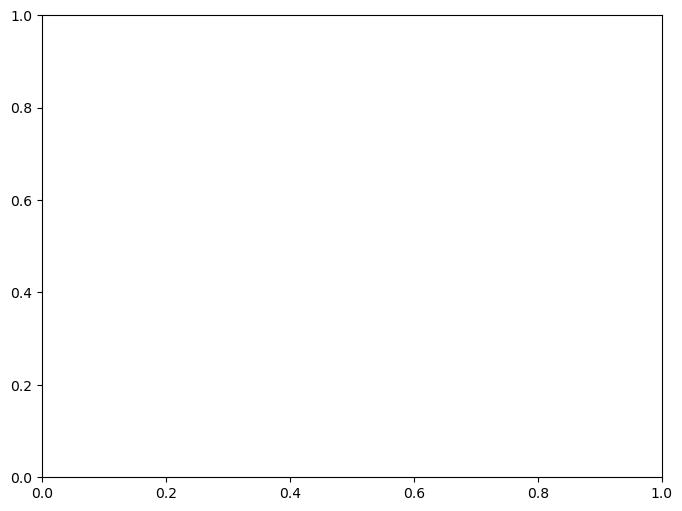

In [10]:
           
image_an=img_in_0*1.0/np.max(img_in)
ifile = '*'+annulus+'_U_phi_corr_tel+unres.fits'
files = os.listdir(dirdat0)     
for file in files:
    if fnmatch.fnmatch(file, ifile):
        hdul = fits.open(dirdat0 + file)
        u_phi_nondec = hdul['Primary'].data
        n_in=u_phi_nondec.shape[0]
adc=int(400)#int(n/2.-20*ps)
bdc=int(n_in-400)#int(n/2.+20*ps)

u_phi_rotated=f.rotate_image(u_phi_nondec * (R>1),angle,xc,yc)  #* (R<Rlimit)

image=u_phi_rotated*1.0
lim=35
fig, ax = plt.subplots(1, 1,figsize=(8,6))
d = (n-1) * ps / 2
d=d_in
xc=xc_in+d
yc=yc_in+d
xr = np.linspace(0, n, num=n)
yr = np.linspace(0, n, num=n)
xr = xr-xc
yr = yr-yc
Xr, Yr = np.meshgrid(xr, yr)            
R_deproj=np.sqrt(Xr**2 + (Yr/cosi)**2)
R_deproj=R_deproj


var_ar=[]
u_mean_ar=[]
q_mean_ar=[]
snr_ar=[]

img_noise, R_noise, _, _, _,_,_= LoadImage_noise(dir)
mask_backg = (R_noise < 460) & (R_noise >=360)
backg_q=img_noise[mask_backg]
backgrms=np.nanstd(backg_q) 

noise=np.mean(np.abs(backg_q)) 

image_rotated_0=image_rotated*1.0
u_phi_rotated_0=u_phi_rotated*1.0


image_rotated=image_rotated#*R_deproj*R_deproj
u_phi_rotated=u_phi_rotated#*R_deproj*R_deproj

#image_rotated=np.sinh(image_rotated)*1.0*R_deproj
for i_r in range (2,50,1):

    width=math.sqrt(i_r)/2
    
    mask = (R_deproj < i_r+width) * (R_deproj >=(i_r-width))*((Yr/cosi)<5)*((Yr/cosi)>-5)
    #plt.imshow(mask, extent=(-d, d, d/cosi,-d/cosi))
    #plt.xlim(-lim*ps, lim*ps)
    #plt.ylim(-lim*ps, lim*ps)
    #plt.colorbar()
    #plt.show()
    image_u=u_phi_rotated[mask]
    image_q=image_rotated[mask]

    if np.mean(image_rotated_0[mask])<backgrms/2: #this closely correspond to the snr contour
        break

    i_r_stop=i_r
    error=abs(np.mean(image_u))#+np.nanstd(image_u)/math.sqrt(len(image_u))
    u_mean=np.mean(image_u)
    q_mean=np.mean(image_q)
    snr=q_mean/error

    snr_ar.append(snr)
    var_ar.append(error)
    u_mean_ar.append(u_mean)
    q_mean_ar.append(q_mean)



i_rad=[float(x)*ps for x in range (2,i_r_stop+1,1)]    

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
ax1.errorbar(i_rad,q_mean_ar, yerr = var_ar,ecolor='blue',color='black',fmt='o')

max_q_mean_ar_index = np.argmax(q_mean_ar)
# Create reference starting from max_q_mean_ar_index
reference = [np.max(q_mean_ar) / ((i/i_rad[max_q_mean_ar_index])**2) for i in i_rad[max_q_mean_ar_index:]]
ax1.plot(i_rad[max_q_mean_ar_index:],reference,color='grey')

#HERE IS the TITLE
#fig.suptitle(annulus, fontsize=28)
if fittype=='Q_phi': ax1.set_ylabel(r'Q$_\phi$/max(Q$_\phi$)', fontsize=24)     
if fittype=='PI': ax1.set_ylabel(r'I$_{\rm pol}$/max(I$_{\rm pol}$)', fontsize=24)     
ax1.set_xlabel('Distance from the star, mas', fontsize=24)

img2=ax2.imshow(np.arcsinh(image_rotated_0),vmax=np.max(np.arcsinh(image_rotated_0)), extent=(-d, d, d/cosi,-d/cosi))
ax2.plot(xc*ps-d, yc*ps-d, "*", color='red')
ax2.plot(points_rotx*ps-d,(points_roty*ps-d)/cosi, lw=2, color='red')

ax2.set_xlim(-lim*ps, lim*ps)
ax2.set_ylim(-lim*ps, lim*ps)
ax2.set_xlabel('mas', fontsize=24)
ax2.set_ylabel('mas', fontsize=24)
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)       
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar=fig.colorbar(img2, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=20)
northeast_rotated_depr_ax(angle,xc,yc,35,cosi,ps,ax2,coef=3) 
plt.savefig(savefig1+star+'_'+annulus+'_maj_ax_radial_profile_both.jpeg',bbox_inches='tight', pad_inches=0.1)
plt.close()


plt.errorbar(i_rad,q_mean_ar, yerr = var_ar,ecolor='blue',color='black',fmt='o')

plt.plot(i_rad[max_q_mean_ar_index:],reference,color='grey')

#plt.title(annulus, fontsize=28)#+' mean q_phi brightness over annulies in linear scale')
if fittype=='Q_phi': plt.ylabel(r'Q$_\phi$/max(Q$_\phi$)', fontsize=24)
if fittype=='PI': plt.ylabel(r'I$_{\rm pol}$/max(I$_{\rm pol}$)', fontsize=24)
plt.xlabel('Distance from the star, mas', fontsize=24)
plt.savefig(savefig1+star+'_'+annulus+'_maj_ax_radial_profile.jpeg',bbox_inches='tight', pad_inches=0.1) 
plt.close()

## estimation of the signal in Uphi before deconvolution

In [ ]:
annulus='V'

ifile = '*'+annulus+'_U_phi_corr_tel+unres.fits'
files = os.listdir(dirdat0)     
for file in files:
    if fnmatch.fnmatch(file, ifile):
        hdul = fits.open(dirdat0 + file)
        u_phi_nondec = hdul['Primary'].data
        n_in=u_phi_nondec.shape[0]

        
ifile = '*'+annulus+'_Q_phi_corr_smearing_tel+unres+PSF_smear.fits'
files = os.listdir(dirdat0)     
for file in files:
    if fnmatch.fnmatch(file, ifile):
        hdul = fits.open(dirdat0 + file)
        q_phi_nondec = hdul['Primary'].data
        n_in=q_phi_nondec.shape[0]       
        
lim=35
d = (n-1) * ps / 2
d=d_in
xc=xc_in+d
yc=yc_in+d
xr = np.linspace(0, n, num=n)
yr = np.linspace(0, n, num=n)
xr = xr-xc
yr = yr-yc
Xr, Yr = np.meshgrid(xr, yr)            
R=np.sqrt(Xr**2 + (Yr)**2)



var_ar=[]
u_mean_ar=[]
q_mean_ar=[]
snr_ar=[]

u_phi_total=np.sum((u_phi_nondec)*(R<40))
u_phi_total_abs=np.sum(abs(u_phi_nondec)*(R<40))
q_phi_total_abs=np.sum((q_phi_nondec)*(R<40))

f.plotImagesdepr(np.arcsinh(u_phi_nondec), np.arcsinh(q_phi_nondec), 30, 1,xc,yc)
plt.show()
plt.close()

print(q_phi_total_abs,u_phi_total_abs, u_phi_total_abs/q_phi_total_abs)

print(q_phi_total_abs,u_phi_total, u_phi_total/q_phi_total_abs)
